# Data Science Project
## Content Cluster | Basic Architecture 


##### Marissa Montano & Mohamed Al-Rasbi


______

#### Why do you care?


   The goal of our project is to cluster songs by lyrical content. We will be using a kaggle dataset from Gyanendra Mishra (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics/data) and we will be using the python Sklearn library to actually help us process the data. We want to see what main communities of songs are out there, and what themes/topics and genres usually group together. Hopefully we can find out if most artists fall victim to following a generic “genre formula” when it comes to writing lyrics.


   The methods and techniques we have been using to use to cluster these lyrics are term frequency-inverse document frequency (TF-IDF), word embeddings (Word2vec), singular value decomposition (SVD), K-Means Clustering, Spectral Clustering, Gaussian Mixture Models, and Topic modeling (LDA). We are going to compare two the method of extracting the lyrics to a feature (ie. with mapping or embedding) using TF-IDF and Word2vec, then we are going going to (potentially) use the SVD reduction method (we might have to reduce our dimensions if our laptops don't have the processing power to cluster with all features),we are going to compare three clustering methods:K-Means Clustering, Spectral Clustering, and Gaussian Mixture Models, and lastly we are going to try to grab common topics from the clusters using LDA.


   The goal from this project is to work with natural language processing (NLP). We could have analyzed data from Spotify and just clustered based off of musical measurements like valence, but that seems like a trivial task. We feel like we would get more out of this project this semester if we analyzed the content of the songs (lyrics) instead.


In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import multiprocessing
#clustering
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture

#vectorizing
from nltk.tokenize import sent_tokenize, word_tokenize 
from gensim.models import Word2Vec # pip install gensim==3.4.0
from gensim.models.doc2vec import Doc2Vec,  TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marissa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Marissa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def preprocess(lyrics):
    # Ignore case
    lyrics = lyrics.lower()
    
    # Remove ',!?:. \n
    lyrics = ''.join([word.strip(",!?:") for word in lyrics])
    lyrics = lyrics.replace('\n', ' ')
    lyrics = lyrics.replace('\'', '')
    
    # Remove everything between hard brackets
    lyrics = re.sub(pattern="[\(\[].*?[\)\]]", repl='', string=lyrics)

    # Remove x4 and (x4), for example
    lyrics = re.sub(pattern="(\()?x\d+(\))?", repl=' ', string=lyrics)
    lyrics = lyrics.replace('  ', ' ')
    
    #remove stop words
    lyrics = [w for w in lyrics.split() if not w in stopwords.words('english')] 
    
    #return list of words
    return " ".join(lyrics), lyrics

In [9]:
def loadData(file_name, sub_list=False):
    df = pd.read_csv(file_name)
    df.dropna(inplace=True)
    if sub_list == True:
        #import only 1000 data points because my laptop SUCKS
        df = df.head(5000)
    # Clean data
    df = df.dropna()
    #drop Other, Not Avalible 
    df.drop( df[ df['genre'] == 'Other' ].index , inplace=True)
    df.drop( df[ df['genre'] == 'Not Available' ].index , inplace=True)
    df.drop( df[ df['genre'] == 'Alkebulan' ].index , inplace=True) 

    for i, row in df.iterrows():
        sentense, words = preprocess(df.loc[i,'lyrics'])
        df.loc[i,'lyrics'] = sentense
        df.loc[i, 'tag'] = TaggedDocument(words=words, tags=[df.loc[i, 'song']+str(i)])

    X_train, X_test, y_train, y_test = train_test_split(df.drop(['genre'], axis=1), df['genre'], test_size=0.20, random_state=42)
    
    return (X_train, X_test, y_train, y_test)

In [6]:
def dataExploration(df):
    genre_counts = df.value_counts()
    # plotting 
    plt.pie(genre_counts.values, labels = genre_counts.index, autopct='%1.0f%%')
    plt.title('Count of songs per genre')
    plt.savefig('genre_breakdown.png', dpi=580)
    plt.show()


In [7]:
def clusterComparison(X_train, X_test, y_train, y_test, n_comp): 
    #params
    n_components = n_comp
    n_clusters = y_train.nunique()
    
    # TFIDF | turn lyrics to vectors
    tfidf = TfidfVectorizer(stop_words = 'english')
    X_tfidf = tfidf.fit_transform(X_train['lyrics'])
    
    # Word2Vec Doc2vec | turn lyrics to vectors
    min_word_count = 3
    num_workers = multiprocessing.cpu_count()
    model = Doc2Vec(X_train['tag'].tolist(), workers=num_workers)
    X_w2v = model.docvecs.vectors_docs

    
    # SVD | dimension reduction
    #svd = TruncatedSVD(n_components=n_components, random_state = 0)
    #X_final = svd.fit_transform(X)
    
    # clusters
    kmeans_tf = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans_wv = KMeans(n_clusters=n_clusters, random_state=0)
    spectral_tf = SpectralClustering(n_clusters=n_clusters, random_state=0)
    spectral_wv = SpectralClustering(n_clusters=n_clusters, random_state=0)
    
    gmm = GaussianMixture(n_components=n_clusters)
    models_tf = [kmeans_tf, spectral_tf]
    models_wv = [kmeans_wv, spectral_wv]
    
    accuracy = []
    for model in models_tf:
        # clustering on lyrics
        X_clustered = model.fit_predict(X_tfidf)
        # display by groups
        df_plot = pd.DataFrame({'Genre':y_train,  'Cluster':X_clustered})
        accuracy.append(df_plot)
        print(df_plot.head(20))
        
    for model in models_wv:
        # clustering on lyrics
        X_clustered = model.fit_predict(X_w2v)
        # display by groups
        df_plot = pd.DataFrame({'Genre':y_train,  'Cluster':X_clustered})
        accuracy.append(df_plot)
        print(df_plot.head(20))

    return accuracy


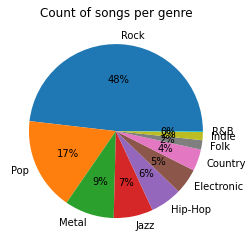

           Genre  Cluster
1979  Electronic        0
3639        Jazz        6
6237        Rock        0
6249        Rock        0
1412     Country        8
2424        Rock        3
4734        Jazz        6
703         Rock        3
417        Metal        0
2249        Rock        8
6749  Electronic        1
4087       Metal        0
3549        Jazz        0
1950         Pop        4
4815         Pop        5
5827        Rock        8
2353     Hip-Hop        3
6283        Folk        1
2359     Hip-Hop        1
5772        Rock        8
           Genre  Cluster
1979  Electronic        1
3639        Jazz        8
6237        Rock        1
6249        Rock        1
1412     Country        9
2424        Rock        5
4734        Jazz        8
703         Rock        8
417        Metal        1
2249        Rock        9
6749  Electronic        1
4087       Metal        8
3549        Jazz        1
1950         Pop        4
4815         Pop        1
5827        Rock        1
2353     Hip

In [10]:
X_train, X_test, y_train, y_test = loadData('lyrics.csv', True) 
dataExploration(y_train)
n_components = 20
accuracy = clusterComparison(X_train, X_test, y_train, y_test, n_components)

#for i, row in accuracy[0].iterrows():
#    print(accuracy[0].loc[i, 'Cluster'], accuracy[0].loc[i, 'Genre'])
